In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
from scipy.sparse import coo_matrix
from shapely.geometry import Point, LineString, MultiLineString
from shapely import ops
import networkx as nx
import matplotlib.pyplot as plt
import neptune
import folium
import pickle
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load data for network creation
# read data from file
datasize = '2M'
location = 'stavanger'
data_date = '202204'
eval_date = '202205'

orig_filename = '../data/processed/'+data_date+'_points_'+location+'_cleaned_meta_'+datasize+'_dualSplit_2.parquet'
gdf = gpd.read_parquet(orig_filename)
# Transform to desired CRS
# 4326 for WGS 84 (global) // 32632 for UTM 32N (Norway)
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation

In [4]:
# load evaluation data
eval_file = eval_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../data/processed/' + eval_file + '.parquet'
test_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
test_gdf.to_crs(crs, inplace=True)  # Transformation
all_test_trajectories = mpd.TrajectoryCollection(test_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_test_trajectories)
selection_step = 25
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = test_gdf.mmsi.unique()[selection]
test_trajectories = all_test_trajectories.filter('mmsi', mmsis.tolist())

In [5]:
# load significant points
#sp_gdf = gpd.read_parquet('../data/processed/202204_significant_points_DP10_stavanger_full_UTM.parquet')
#sp_gdf.to_crs(crs, inplace=True)  # Transformation

https://app.neptune.ai/jandrik91/Maritime-Traffic-Network/e/MAR-444
Number of AIS messages: 1794132
Number of trajectories: 4666
Coordinate Reference System (CRS): EPSG:32632
Calculating significant turning points with Douglas Peucker algorithm (tolerance = 10) ...
Number of significant points detected: 134855 (7.52% of AIS messages)
Time elapsed: 1.53 minutes
Adding course over ground before and after each turn ...
Done. Time elapsed: 0.88 minutes
Calculating waypoints with HDBSCAN (min_samples = 30) ...
Distance metric: mahalanobis
470 clusters detected
Time elapsed: 2.85 minutes
Constructing maritime traffic network graph from waypoints and trajectories...
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!
------------------------
Unpruned Graph:
Number of nodes: 470 (12 isolated)
Number of edges: 1511
Network is (weakly) connected: False
------------------------
Time elapsed: 5.24 minutes
Pruning...
------------------------
Pruned Graph:
Number of nodes: 464 (7 i

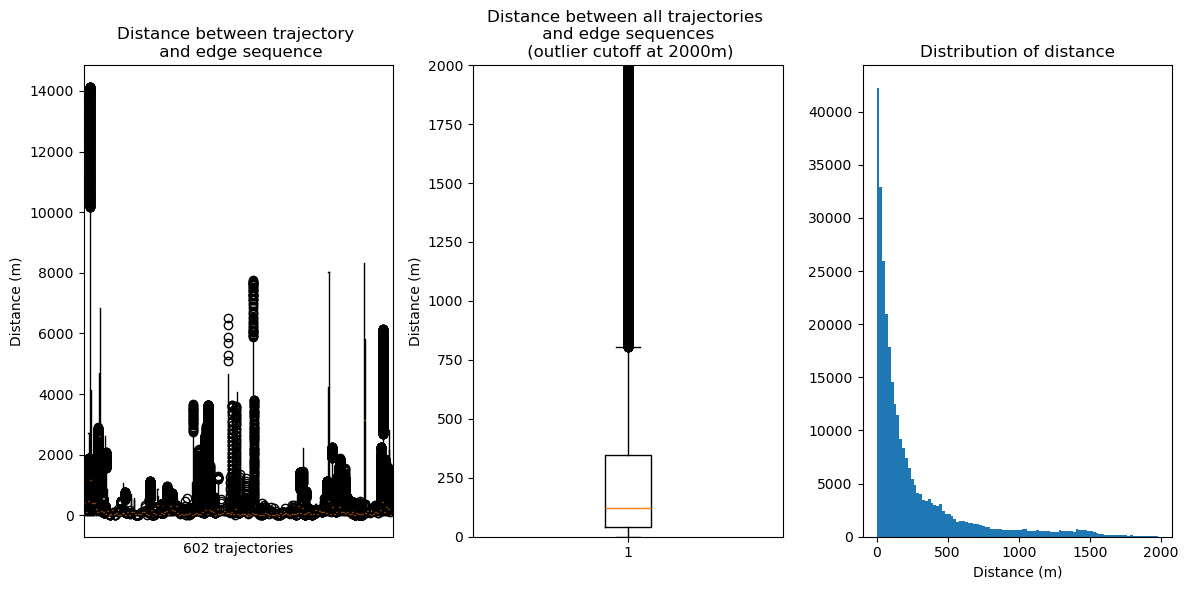

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 33 operations to synchronize with Neptune. Do not kill this process.
All 33 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jandrik91/Maritime-Traffic-Network/e/MAR-444/metadata
https://app.neptune.ai/jandrik91/Maritime-Traffic-Network/e/MAR-445
Number of AIS messages: 1794132
Number of trajectories: 4666
Coordinate Reference System (CRS): EPSG:32632
Calculating significant turning points with Douglas Peucker algorithm (tolerance = 10) ...
Number of significant points detected: 134855 (7.52% of AIS messages)
Time elapsed: 1.62 minutes
Adding course over ground before and after each turn ...
Done. Time elapsed: 0.92 minutes
Calculating waypoints with HDBSCAN (min_samples = 35) ...
Distance metric: mahalanobis
396 clusters detected
Time elapsed: 3.06 minutes
Constructing maritime traffic network graph from waypoints and trajectories...
Progress: 10

In [ ]:
# make experiments
vals_ms = [30, 35]
vals_DP = []
vals_v34 = []
vals_v5 = []
vals_max_dist = []
vals_max_angle = []


for i in range (0, len(vals_ms)):
    run = neptune.init_run(
        project="jandrik91/Maritime-Traffic-Network",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
    )  # your credentials

    network = MaritimeTrafficNetwork(gdf, crs)
    network.get_trajectories_info()
    
    # parameters
    tolerance = 10 # DP tolerance parameter 0.0002
    method = 'HDBSCAN'      # 'DBSCAN' , 'HDBSCAN', 'OPTICS'
    metric = 'mahalanobis'  # 'euclidean', 'mahalanobis', 'haversine'
    min_samples = vals_ms[i]
    min_cluster_size = vals_ms[i]
    eps = 0
    V = np.diag([1, 1, 0.01, 0.01, 5e-4])  # mahalanobis distance parameter matrix V = np.diag([1, 1, 0.01, 0.01, 5e-4])  seems to be good
    max_distance = 10
    max_angle = 45
    merge_stops = True
    merge_stops_speed = 2
    pruning = 1
    model = data_date+'_waypoints_DP' + str(tolerance) + '_' + method + str(min_samples) +'_'+location+'_'+datasize+'_UTM'
    # save hyperparameters
    params = {
        'Data':orig_filename,
        'DP_tolerance':tolerance,
        'clustering_method':method,
        'clustering_metric':metric,
        'clustering_min_samples':min_samples,
        'clustering_min_cluster_size':min_cluster_size,
        'clustering_eps':eps,
        'clustering_metric_V':V,
        'graph_generation_max_distance':max_distance,
        'graph_generation_max_angle':max_angle
    }
    network.set_hyperparameters(params)
    
    # calculate significant turning points using Douglas Peucker algorithm
    network.calc_significant_points_DP(tolerance)
    #network.init_precomputed_significant_points(sp_gdf)
    
    # compute waypoints
    network.calc_waypoints_clustering(method=method, min_samples=min_samples, min_cluster_size=min_cluster_size,
                                      eps=eps, metric=metric, V=V)
    # make graph from waypoints
    network.make_graph_from_waypoints(max_distance=max_distance, max_angle=max_angle)
    
    # merge stop points
    if merge_stops:
        network.merge_stop_points(max_speed=merge_stops_speed)
    
    # prune graph
    network.prune_graph(pruning)

    # evaluate
    all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(test_trajectories)

    # save experiment
    run["model"]=model
    run["algorithm"]='V7.0(SSPD)'
    run["n_points"]=len(network.gdf)
    run["n_nodes"]=network.G_pruned.number_of_nodes()
    run["n_edges"]=network.G_pruned.number_of_edges()
    run["n_isolated"]=nx.number_of_isolates(network.G_pruned)
    run["merge_stops"] = merge_stops
    run["merge_stops_speed"] = merge_stops_speed
    run["pruning"] = pruning
    
    params = network.hyperparameters
    params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
    params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
    params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
    run["parameters"] = params
    
    run["test_data"] = {'eval_file':eval_file,
                        'selection_start':selection_start,
                        'selection_end':selection_end,
                        'selection_step':selection_step,
                        'n_trajectories':n_trajectories}
    
    run["plot"].upload(fig)
    run["summary"] = summary
    
    run.stop()

In [ ]:
# save network as pickle object
#fileObj = open('../data/interim/202204_waypoints_DP10_HDBSCAN15_stavanger_full_UTM.obj', 'wb')
#pickle.dump(network, fileObj)
#fileObj.close()